In [1]:
import os, sys
sys.path.append('src')
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

In [2]:
pr_max_dict = pickle.load(open('data/tables_and_infos/pr_max_dict_ibl.pkl', 'rb'))
pr_max_dict

{0: np.float64(51.0),
 1: np.float64(74.0),
 2: np.float64(62.0),
 3: np.float64(29.0),
 4: np.float64(25.0),
 5: np.float64(33.0),
 6: np.float64(48.0),
 7: np.float64(14.0)}

## Load IBL Data

Now let's load IBL (Neuropixels) data in a similar way

In [3]:
from loader.data_loader_ibl import load_session_data as load_ibl_session_data

# Load an IBL session
# session_ind is the EID (experiment ID) string
# session_idx is the integer index for caching

# First, let's see what EIDs are available
with open("/u/jyao7/NeuroPaint/data/tables_and_infos/ibl_eids.txt") as file:
    ibl_eids = [line.rstrip() for line in file]

print(f"Total IBL sessions available: {len(ibl_eids)}")
print(f"First 5 EIDs: {ibl_eids[:5]}")

Total IBL sessions available: 20
First 5 EIDs: ['f312aaec-3b6f-44b3-86b4-3a0c119c0438', '51e53aff-1d5d-4182-a684-aba783d50ae5', '88224abb-5746-431f-9c17-17d7ef806e6a', 'c7248e09-8c0d-40f2-9eb4-700a8973d8c8', '4b00df29-3769-43be-bb40-128b1cba6d35']


In [4]:
# Load a specific IBL session
print(len(ibl_eids))
session_idx = 0  # Cache index
session_eid = ibl_eids[session_idx]  # Get the EID string

print(f"Loading session {session_idx}: {session_eid}")

# Load the IBL data
ibl_spike_data, ibl_behavior_data, ibl_area_ind_list, ibl_is_left, ibl_is_ALM, ibl_trial_type = load_ibl_session_data(
    session_eid, session_idx
)

print(f"\nIBL Data shapes:")
print(f"Spike data: {ibl_spike_data.shape} (N × T × K)")
print(f"Trial type (choice): {ibl_trial_type.shape}")
print(f"Number of neurons: {ibl_spike_data.shape[0]}")
print(f"Time bins per trial: {ibl_spike_data.shape[1]}")
print(f"Number of trials: {ibl_spike_data.shape[2]}")

20
Loading session 0: f312aaec-3b6f-44b3-86b4-3a0c119c0438
EID f312aaec-3b6f-44b3-86b4-3a0c119c0438
Loading EID f312aaec-3b6f-44b3-86b4-3a0c119c0438 from cached data

IBL Data shapes:
Spike data: (1504, 200, 533) (N × T × K)
Trial type (choice): (533, 1)
Number of neurons: 1504
Time bins per trial: 200
Number of trials: 533


In [5]:
area_psths = {}
areaoi = ["PO", "LP", "DG", "CA1", "VISa", "VPM", "APN", "MRN"]
for area in areaoi:
    area_mask = [area in name for name in ibl_area_ind_list]
    area_spike_data = ibl_spike_data[area_mask, :, :]
    area_psth = area_spike_data
    area_psths[area] = area_psth

print(list(map(lambda x: (x, area_psths[x].shape), area_psths.keys())))

[('PO', (237, 200, 533)), ('LP', (206, 200, 533)), ('DG', (123, 200, 533)), ('CA1', (234, 200, 533)), ('VISa', (314, 200, 533)), ('VPM', (0, 200, 533)), ('APN', (172, 200, 533)), ('MRN', (56, 200, 533))]


/tmp/ipykernel_2990272/1528369648.py:3: RuntimeWarning: Mean of empty slice.
  mean_psth = area_psths[area].mean(axis=0).mean(axis=-1)*100
/u/jyao7/miniconda3/envs/neuropaint/lib/python3.11/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


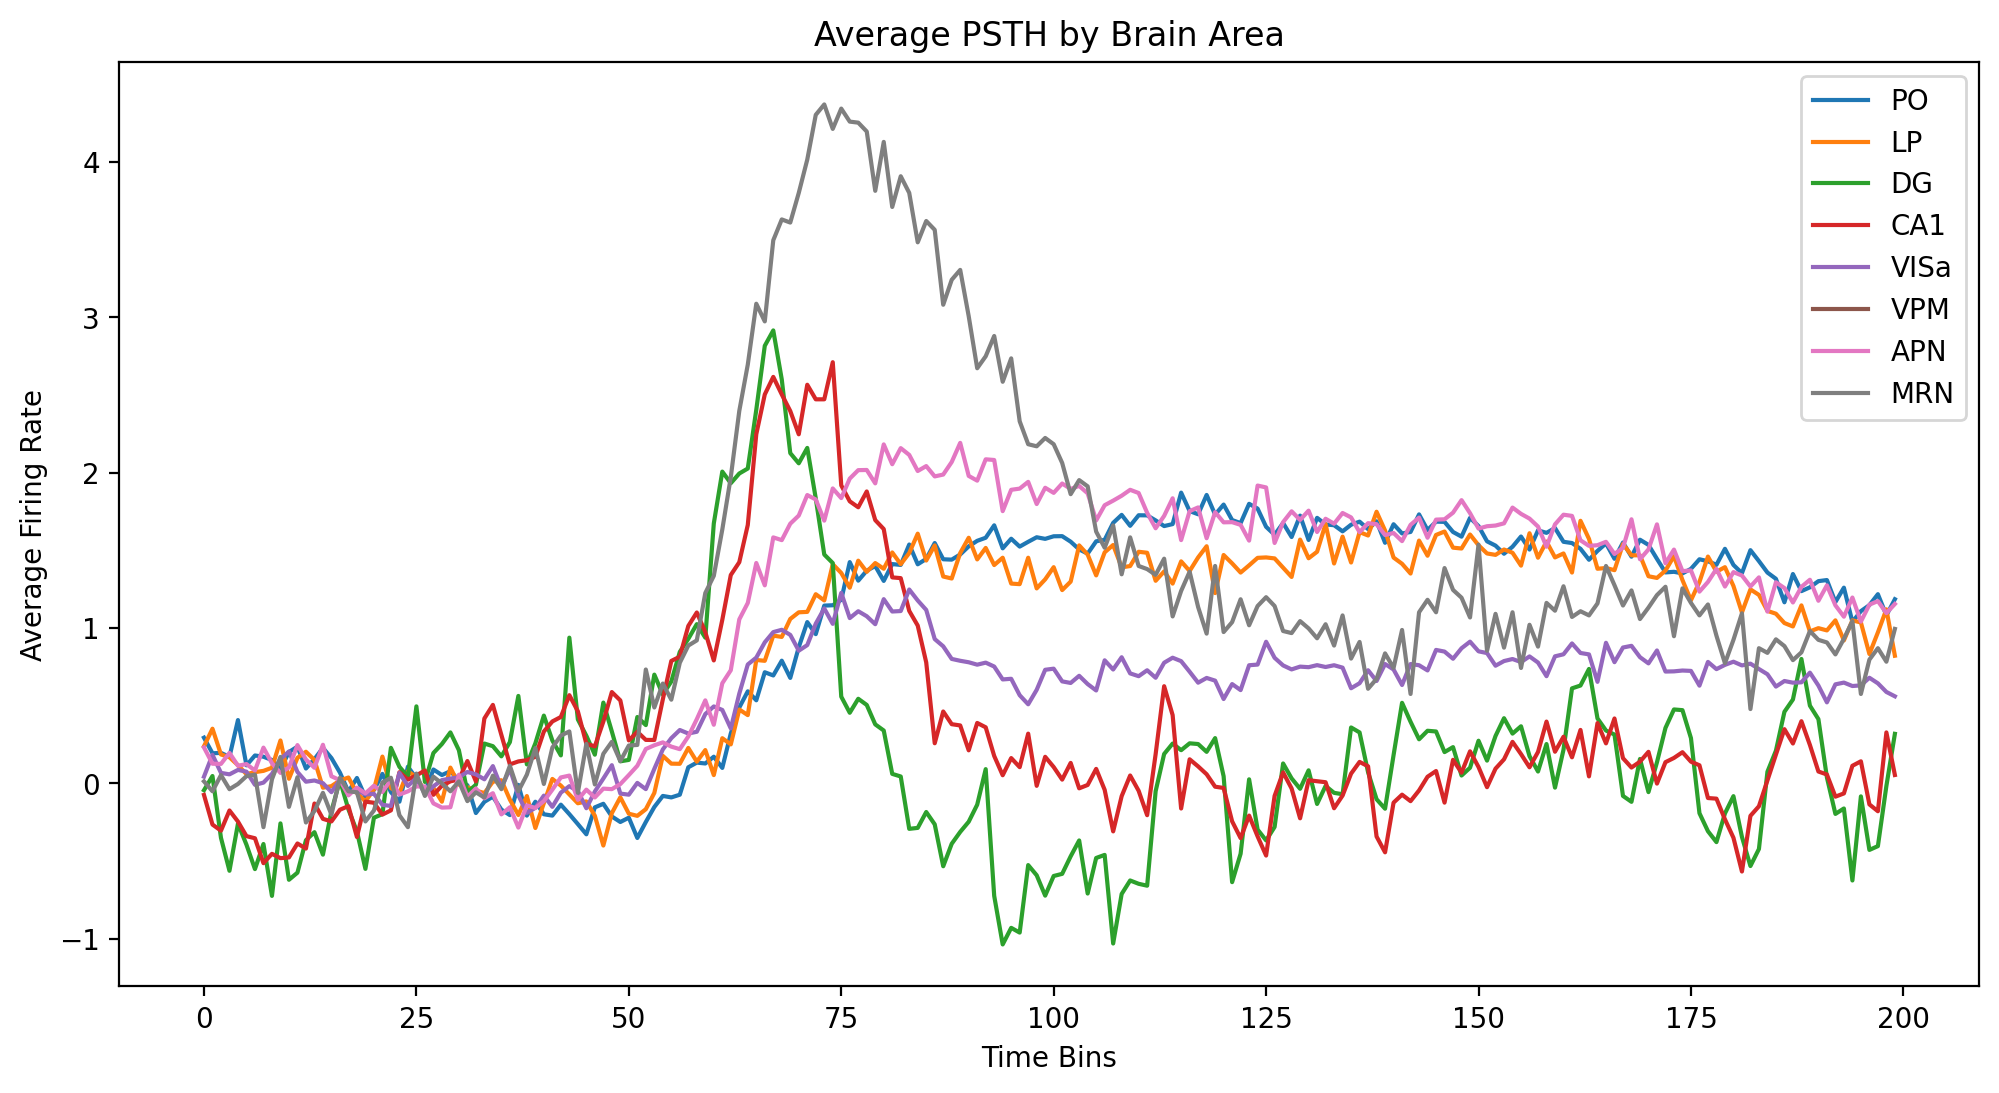

In [6]:
plt.figure(figsize=(12, 6))
for area in areaoi:
    mean_psth = area_psths[area].mean(axis=0).mean(axis=-1)*100
    mean_psth -= mean_psth[:50].mean()
    plt.plot(mean_psth, label=area)
plt.legend()
plt.title("Average PSTH by Brain Area")
plt.xlabel("Time Bins")
plt.ylabel("Average Firing Rate")
plt.show()

Unique brain regions in this session: 26
Brain region indices: ['APN' 'CA1' 'CA3' 'DG-mo' 'DG-po' 'DG-sg' 'HPF' 'LP' 'MB' 'MRN' 'PO'
 'POL' 'VISa1' 'VISa2/3' 'VISa4' 'VISa5' 'VISa6a' 'VISa6b' 'VISam5' 'alv'
 'bsc' 'ccs' 'cing' 'or' 'root' 'void']


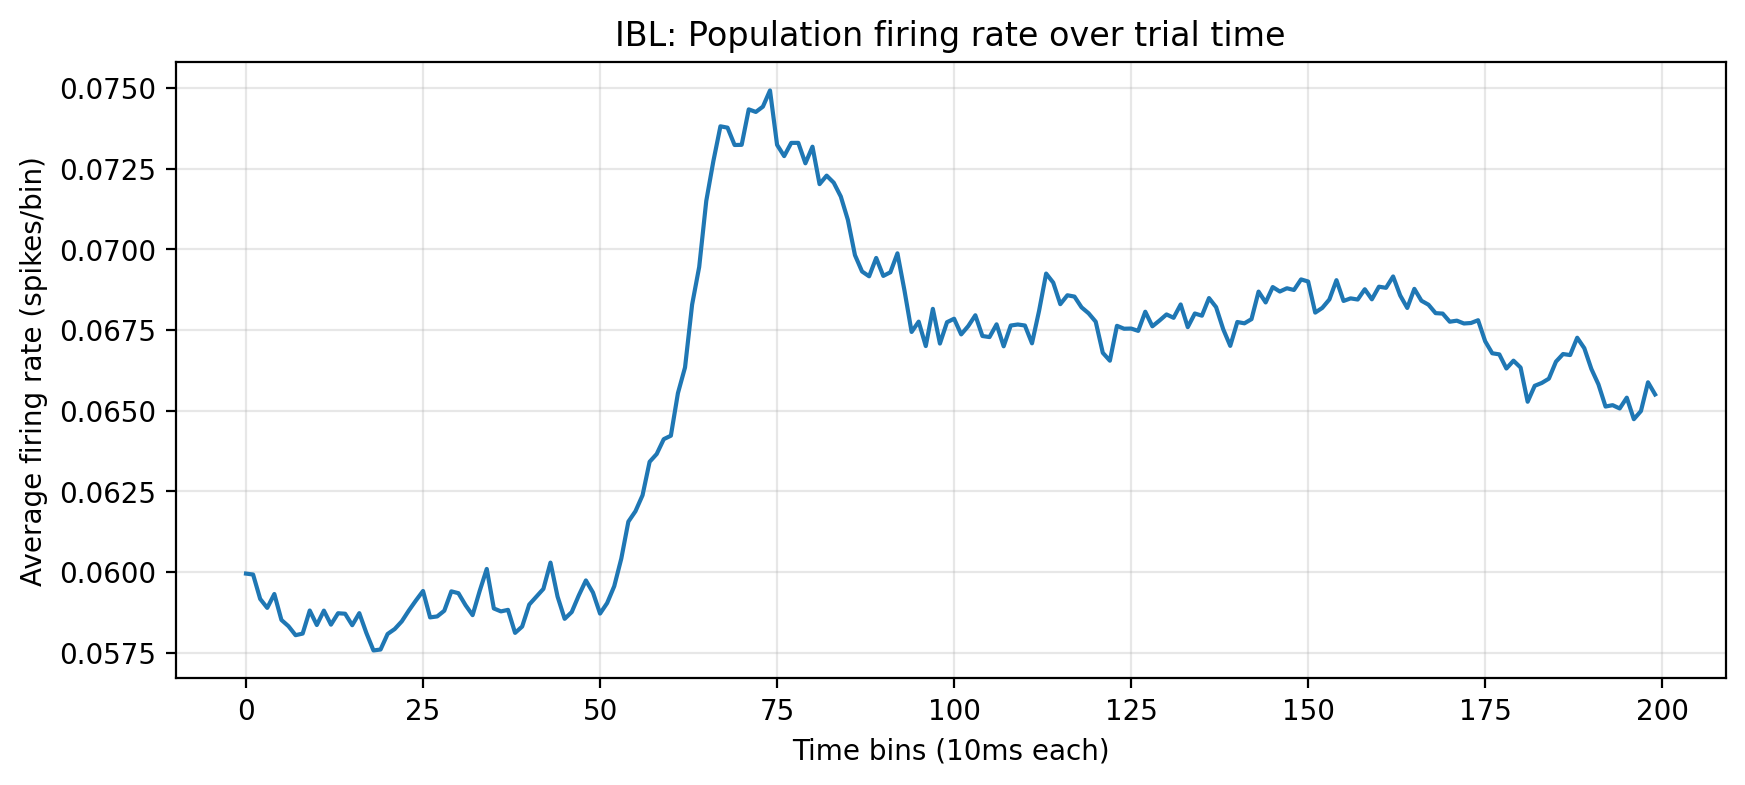

In [7]:
# Explore IBL brain regions
print(f"Unique brain regions in this session: {len(np.unique(ibl_area_ind_list))}")
print(f"Brain region indices: {np.unique(ibl_area_ind_list)}")

# Plot average firing rate over time (similar to MAP data)
ibl_time_data = ibl_spike_data.mean(axis=0).mean(axis=-1)
plt.figure(figsize=(10, 4))
plt.plot(ibl_time_data)
plt.xlabel('Time bins (10ms each)')
plt.ylabel('Average firing rate (spikes/bin)')
plt.title('IBL: Population firing rate over trial time')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
from utils.config_utils import config_from_kwargs, update_config

kwargs = {
        "model": f"include:src/configs/mae_with_hemisphere_embed_and_diff_dim_per_area_ibl.yaml",
    }

config = config_from_kwargs(kwargs)
config = update_config("src/configs/finetune_sessions_trainer.yaml", config)

In [9]:

area2ind = lambda area: areaoi.index(area) if area in areaoi else -1
areaoi_ind = np.array([area2ind(area) for area in areaoi])
ibl_area_ind = np.array([area2ind(area) for area in ibl_area_ind_list])
areaoi_ind, ibl_area_ind

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 0,  0,  0, ..., -1, -1, -1], shape=(1504,)))

In [10]:
from models.mae_linear import Linear_MAE

model = Linear_MAE(config, area_ind_list_list=[ibl_area_ind], areaoi_ind=areaoi_ind, eids=[session_eid])
model

/u/jyao7/NeuroPaint/src/models/mae_linear.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.lat_areas = torch.tensor([area.repeat(n_latents_dict[area]) for area in areaoi_ind]).flatten().tolist()


Linear_MAE(
  (encoder): LinearEncoder(
    (stitcher): LinearStitcher(
      (session_area_linears): ModuleDict(
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_0): Embedding(174, 32)
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_1): Embedding(206, 32)
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_2): Embedding(0, 32)
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_3): Embedding(234, 32)
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_4): Embedding(0, 32)
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_5): Embedding(0, 32)
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_6): Embedding(172, 32)
        (f312aaec-3b6f-44b3-86b4-3a0c119c0438_7): Embedding(56, 32)
      )
      (hemisphere_embed): Embedding(2, 32)
    )
    (U_layer): Linear(in_features=288, out_features=128, bias=True)
    (V_layer): Linear(in_features=128, out_features=160, bias=True)
  )
  (decoder): LinearDecoder(
    (session_area_linears): ModuleDict(
      (f312aaec-3b6f-44b3-86b4-3a0c119c0438_0): Embedding(20, 174)
      (f3

In [ ]:
session_spikes = torch.tensor(ibl_spike_data)
session_regions = torch.tensor(ibl_area_ind).expand(session_spikes.size(-1), -1).T
is_left = torch.zeros(session_regions.size())
session_spikes.size(), session_regions.size(), is_left.size()

(torch.Size([1504, 200, 533]),
 torch.Size([1504, 533]),
 torch.Size([1504, 533]))

: 

In [ ]:
model(
    spikes=session_spikes, neuron_regions=session_regions, is_left=is_left, eid=session_eid
)